In [4]:
#Importing all the libraries required for the final project

import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
from tensorflow import keras
import random
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras import layers, models, Model
from sklearn.metrics import precision_score, recall_score, f1_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

# **Identification of Frost in Martian HiRISE Images**

## *(b.) Data Exploration and Pre-processing*

In [7]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/drive/MyDrive/Colab Notebooks/data/')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [8]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## *(c) Training CNN + MLP*

### (i.) To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [9]:
def data_augmentation(image, target_size):
  # Ensure the image is in the correct format
  image = tf.cast(image, tf.float32)
  image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.1)
  image = tf.image.resize(image, [target_size[0], target_size[1]])
  return image

def load_and_preprocess(img_loc, label, is_training=False):

    def _inner_function(img_loc, label, is_training):

      # Convert tensor to native type
      img_loc_str = img_loc.numpy().decode('utf-8')
      label_str = label.numpy().decode('utf-8')

      img = Image.open(img_loc_str).convert('RGB')

      # Convert PIL image to numpy array
      img = np.array(img)
      img = tf.convert_to_tensor(img, dtype=tf.float32)

      if is_training:
        # Apply augmentations for training images
        img = data_augmentation(img, (299,299))

      img = tf.image.resize(img, IMAGE_SIZE)
      img.set_shape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

      return img, 1 if label_str == 'frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label, is_training], [tf.float32, tf.int64])
    X.set_shape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    y.set_shape(())
    return X, y


def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(lambda x, y: tf.py_function(load_and_preprocess,inp=[x, y, True], Tout=[tf.float32, tf.int64]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [10]:
print("Train Data Size After Concatenation:")
print(tf.data.experimental.cardinality(tf_dataset_train).numpy())

num_images = tf.data.experimental.cardinality(tf_dataset_train).numpy() * batch_size

print("Number of images in the concatenated batched dataset:", num_images)

Train Data Size After Concatenation:
928
Number of images in the concatenated batched dataset: 29696


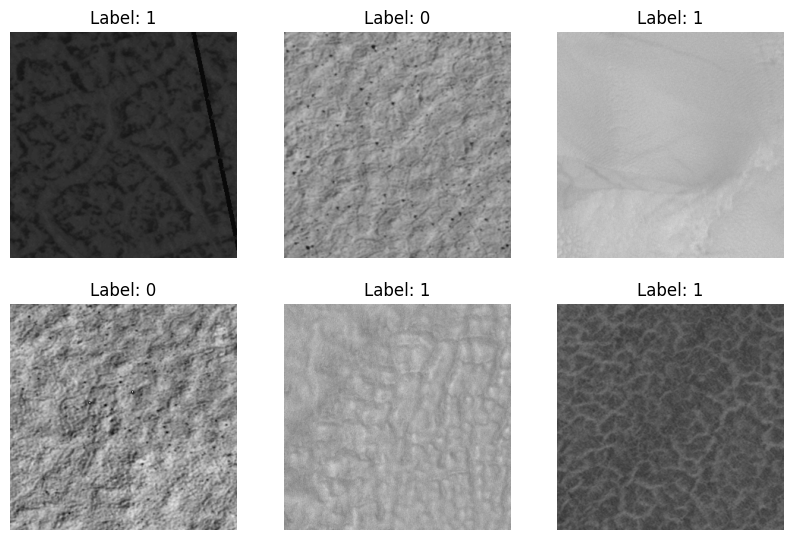

In [13]:
def visualize(dataset, l):
    # Get a batch of data for visualization
    sample_batch = next(iter(dataset))

    # Extract images and labels
    images, labels = sample_batch

    # Display the first 9 images in the batch
    plt.figure(figsize=(10, 10))
    for i in range(0,l):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

    plt.show()


def _fixup_shape(images, labels):
  images.set_shape([None, 299, 299, 3])
  labels.set_shape([None,])
  return images, labels

tf_dataset_train = tf_dataset_train.map(_fixup_shape)
tf_dataset_val = tf_dataset_val.map(_fixup_shape)
tf_dataset_test = tf_dataset_test.map(_fixup_shape)


visualize(tf_dataset_train, 6)

### (ii.) Train a three-layer CNN followed by a dense layer on the data. Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use the softmax function, batch normalization and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train for at least 20 epochs and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

Epoch 1/20
928/928 [==============================] - 2409s 3s/step - loss: 0.9480 - accuracy: 0.7382 - val_loss: 1.3999 - val_accuracy: 0.3336
Epoch 2/20
928/928 [==============================] - 237s 255ms/step - loss: 0.8405 - accuracy: 0.8607 - val_loss: 1.0420 - val_accuracy: 0.8531
Epoch 3/20
928/928 [==============================] - 234s 252ms/step - loss: 0.7815 - accuracy: 0.9028 - val_loss: 0.8724 - val_accuracy: 0.8676
Epoch 4/20
928/928 [==============================] - 239s 257ms/step - loss: 0.7314 - accuracy: 0.9170 - val_loss: 0.9561 - val_accuracy: 0.8516
Epoch 5/20
928/928 [==============================] - 240s 258ms/step - loss: 0.6514 - accuracy: 0.9243 - val_loss: 1.2047 - val_accuracy: 0.7004
Epoch 6/20
928/928 [==============================] - 240s 258ms/step - loss: 0.6461 - accuracy: 0.9378 - val_loss: 2.8454 - val_accuracy: 0.4772
Epoch 7/20
928/928 [==============================] - 238s 255ms/step - loss: 0.6148 - accuracy: 0.9428 - val_loss: 0.8454 - v

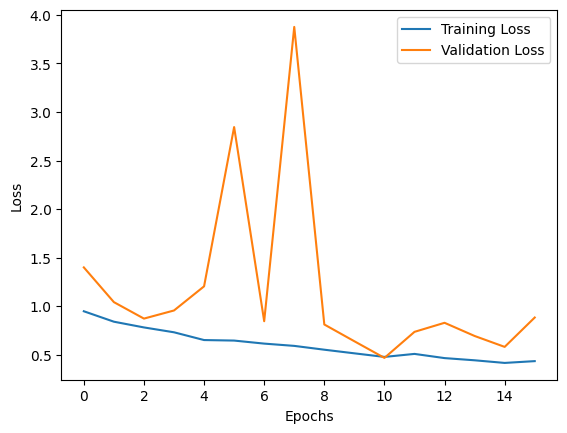

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout


# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(layers.Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(tf_dataset_train, batch_size=32, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (iii.)Report Precision, Recall, and F1 score for your model.

In [ ]:
# Initialize arrays for true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in tf_dataset_test:  # Assuming you have a defined tf_dataset_test

    # Predict
    predicted_probs = model.predict(images, verbose=0)

    # Convert probabilities to class indices
    preds = np.argmax(predicted_probs, axis=1)

    # Labels are already numeric, no need to use np.argmax
    true_labels.extend(labels.numpy())

    predicted_labels.extend(preds)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9028468767274738
Recall: 0.7772754312908983
F1 Score: 0.8353685825714467


## (d) Transfer Learning

(ii.) To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

(iii.) Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 30% as well as ADAM
optimizer. Use cross entropy loss. You can try any batch size, but a batch
size of 8 seems reasonable.

(iv.) Train using the features calculated by networks (EfficientNetB0, ResNet50, and VGG16) for at least 10 epochs (preferably 20 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Assuming you have a tf.data.Dataset tf_dataset_train and tf_dataset_val

# Load pre-trained models
base_model_efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# Freeze all layers in pre-trained models
for layer in base_model_efficientnet.layers:
    layer.trainable = False

for layer in base_model_resnet.layers:
    layer.trainable = False

for layer in base_model_vgg.layers:
    layer.trainable = False

# Build the transfer learning model for EfficientNetB0
model_efficientnet = models.Sequential([
    base_model_efficientnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='sigmoid')  # Assuming num_classes is the number of output classes
])

# Build the transfer learning model for ResNet50
model_resnet = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='sigmoid')
])

# Build the transfer learning model for VGG16
model_vgg = models.Sequential([
    base_model_vgg,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='sigmoid')
])


In [15]:
print("=============== Running EfficientNetB0 Model ===============")

model_efficientnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train models
history_efficientnet = model_efficientnet.fit(tf_dataset_train,
                                              validation_data=tf_dataset_val,
                                              epochs=10,
                                              batch_size=8,
                                              callbacks=[early_stopping]
                                              )


=============== Running EfficientNetB0 Model ===============
Epoch 1/10
928/928 [==============================] - 2536s 3s/step - loss: 0.1709 - accuracy: 0.9335 - val_loss: 0.2635 - val_accuracy: 0.8803
Epoch 2/10
928/928 [==============================] - 245s 264ms/step - loss: 0.1138 - accuracy: 0.9572 - val_loss: 0.4238 - val_accuracy: 0.8536
Epoch 3/10
928/928 [==============================] - 246s 265ms/step - loss: 0.1035 - accuracy: 0.9608 - val_loss: 0.2419 - val_accuracy: 0.8981
Epoch 4/10
928/928 [==============================] - 247s 265ms/step - loss: 0.0951 - accuracy: 0.9634 - val_loss: 0.3787 - val_accuracy: 0.8763
Epoch 5/10
928/928 [==============================] - 246s 264ms/step - loss: 0.0856 - accuracy: 0.9677 - val_loss: 0.3802 - val_accuracy: 0.8838
Epoch 6/10
928/928 [==============================] - 246s 265ms/step - loss: 0.0844 - accuracy: 0.9693 - val_loss: 0.2594 - val_accuracy: 0.8889
Epoch 7/10
928/928 [==============================] - 246s 265ms/

=============== Training and Validation errors Plot for EfficientNetB0 Model ===============


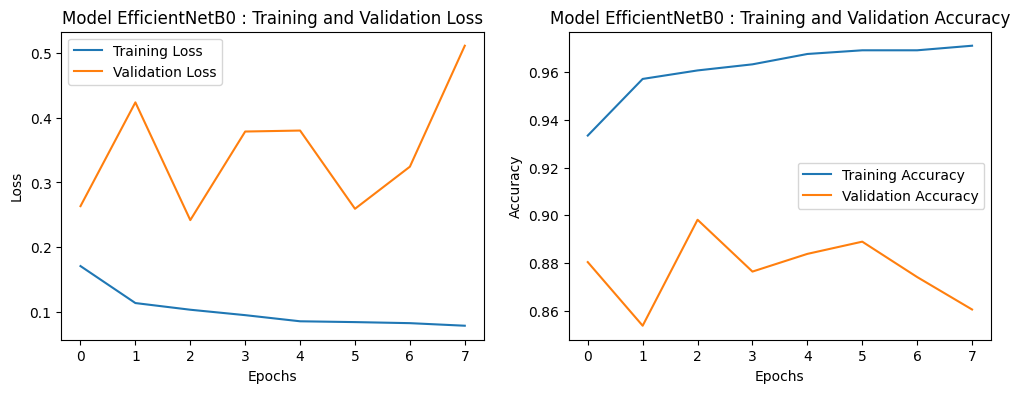

In [17]:
# Plot training and validation errors vs. epochs for EfficientNetB0
print("=============== Training and Validation errors Plot for EfficientNetB0 Model ===============")
histories = []
histories.append(history_efficientnet)

for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Model EfficientNetB0 : Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model EfficientNetB0 : Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [18]:
print("=============== Running ResNet50 Model ===============")

model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train models
history_resnet = model_resnet.fit(tf_dataset_train,
                                  validation_data=tf_dataset_val,
                                  epochs=10,
                                  batch_size=8,
                                  callbacks=[early_stopping]
                                  )

=============== Running ResNet50 Model ===============
Epoch 1/10
928/928 [==============================] - 262s 277ms/step - loss: 0.1172 - accuracy: 0.9569 - val_loss: 0.7690 - val_accuracy: 0.7730
Epoch 2/10
928/928 [==============================] - 256s 275ms/step - loss: 0.0723 - accuracy: 0.9743 - val_loss: 0.4784 - val_accuracy: 0.8439
Epoch 3/10
928/928 [==============================] - 257s 276ms/step - loss: 0.0624 - accuracy: 0.9773 - val_loss: 0.5397 - val_accuracy: 0.8047
Epoch 4/10
928/928 [==============================] - 257s 276ms/step - loss: 0.0551 - accuracy: 0.9798 - val_loss: 0.3171 - val_accuracy: 0.8874
Epoch 5/10
928/928 [==============================] - 257s 276ms/step - loss: 0.0500 - accuracy: 0.9824 - val_loss: 0.2649 - val_accuracy: 0.8794
Epoch 6/10
928/928 [==============================] - 256s 275ms/step - loss: 0.0432 - accuracy: 0.9845 - val_loss: 0.3053 - val_accuracy: 0.8760
Epoch 7/10
928/928 [==============================] - 256s 276ms/step

=============== Training and Validation errors for ResNet50 Model ===============


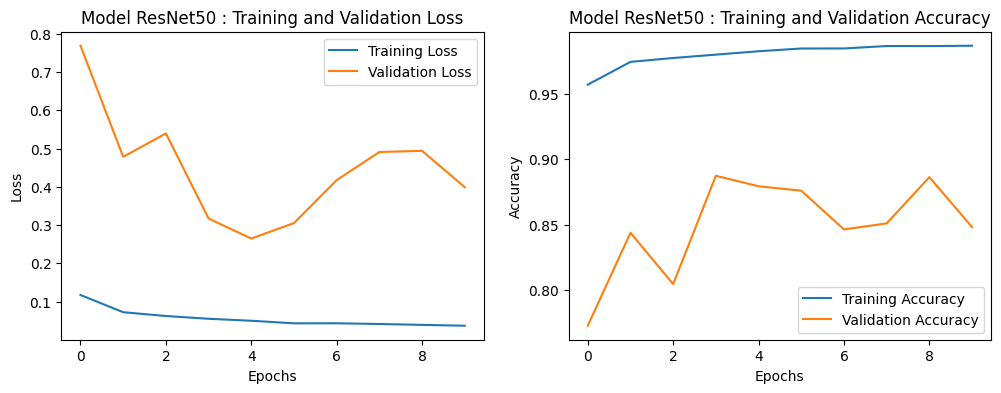

In [19]:
print("=============== Training and Validation errors for ResNet50 Model ===============")

histories = []
histories.append(history_resnet)

for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Model ResNet50 : Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model ResNet50 : Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [20]:
print("=============== Running VGG16 Model ===============")

model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history_vgg = model_vgg.fit(tf_dataset_train,
                            validation_data=tf_dataset_val,
                            epochs=10,
                            batch_size=8,
                            callbacks=[early_stopping]
                            )

=============== Running VGG16 Model ===============
Epoch 1/10
928/928 [==============================] - 261s 278ms/step - loss: 0.1530 - accuracy: 0.9420 - val_loss: 0.8430 - val_accuracy: 0.6807
Epoch 2/10
928/928 [==============================] - 257s 277ms/step - loss: 0.0875 - accuracy: 0.9687 - val_loss: 0.6163 - val_accuracy: 0.7563
Epoch 3/10
928/928 [==============================] - 257s 276ms/step - loss: 0.0760 - accuracy: 0.9719 - val_loss: 0.6332 - val_accuracy: 0.7605
Epoch 4/10
928/928 [==============================] - 257s 277ms/step - loss: 0.0728 - accuracy: 0.9741 - val_loss: 0.9868 - val_accuracy: 0.7256
Epoch 5/10
928/928 [==============================] - 258s 277ms/step - loss: 0.0670 - accuracy: 0.9757 - val_loss: 0.4897 - val_accuracy: 0.8085
Epoch 6/10
928/928 [==============================] - 258s 277ms/step - loss: 0.0624 - accuracy: 0.9768 - val_loss: 0.7892 - val_accuracy: 0.7544
Epoch 7/10
928/928 [==============================] - 258s 278ms/step - 

=============== Training and Validation errors for VGG16 Model ===============


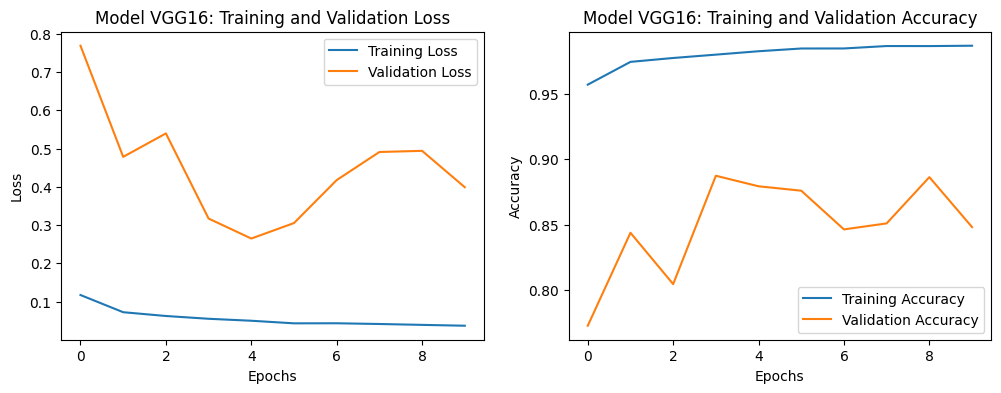

In [21]:
print("=============== Training and Validation errors for VGG16 Model ===============")

histories = []
histories.append(history_resnet)

for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Model VGG16: Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Model VGG16: Training and Validation Accuracy')
    plt.legend()

    plt.show()

#### (v.) Report Precision, Recall, and F1 score for your model.


In [22]:
# Precision, Recall, and F1 score of EfficientNetB0 Model

# Initialize arrays for true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in tf_dataset_test:  # Assuming you have a defined tf_dataset_test

    # Predict
    predicted_probs = model_efficientnet.predict(images, verbose=0)

    # Convert probabilities to class indices
    preds = np.argmax(predicted_probs, axis=1)

    # Labels are already numeric, no need to use np.argmax
    true_labels.extend(labels.numpy())

    predicted_labels.extend(preds)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("=============== EfficientNetB0 Model ===============")
# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

=============== EfficientNetB0 Model ===============
Precision: 0.9793646823411706
Recall: 0.9317073170731708
F1 Score: 0.9549417718431804


In [23]:
# Precision, Recall, and F1 score of ResNet50 Model

# Initialize arrays for true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in tf_dataset_test:  # Assuming you have a defined tf_dataset_test

    # Predict
    predicted_probs = model_resnet.predict(images, verbose=0)

    # Convert probabilities to class indices
    preds = np.argmax(predicted_probs, axis=1)

    # Labels are already numeric, no need to use np.argmax
    true_labels.extend(labels.numpy())

    predicted_labels.extend(preds)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("=============== ResNet50 Model ===============")
# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

=============== ResNet50 Model ===============
Precision: 0.9652920546619905
Recall: 0.9496728138013087
F1 Score: 0.9574187357562671


In [24]:
# Precision, Recall, and F1 score of VGG16 Model

# Initialize arrays for true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in tf_dataset_test:  # Assuming you have a defined tf_dataset_test

    # Predict
    predicted_probs = model_vgg.predict(images, verbose=0)

    # Convert probabilities to class indices
    preds = np.argmax(predicted_probs, axis=1)

    # Labels are already numeric, no need to use np.argmax
    true_labels.extend(labels.numpy())

    predicted_labels.extend(preds)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("=============== VGG16 Model ===============")
# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

=============== VGG16 Model ===============
Precision: 0.9645149570061766
Recall: 0.947531231409875
F1 Score: 0.9559476653462969


### (vi.) Compare the results of transfer learning with those of CNN + MLP model and explain them.

Observing the Precision, Recall and F1-score of CNN+MLP model and comparing these values with the Precision, Recall and F1-score of Transfer Learning, we see that Transfer Learning is outperforming.


---


Transfer Learning Models like EfficientNetB0, ResNet50, and VGG16 are pre-trained on large datasets (e.g., ImageNet), capturing general features from a diverse range of images. When fine-tuning on a relatively smaller dataset, these pre-trained models might converge faster and achieve better training performance. It is also computationally more efficient since most layers are frozen, and only the final layers are trained. Pre-trained models are often deeper and more complex, capturing intricate patterns. Fine-tuning allows leveraging this complexity for the task at hand.


---
In case of CNN+MLP, training a model from scratch on a small dataset may lead to overfitting, especially if the dataset is not sufficiently diverse. Training from scratch may require more computational resources. Model complexity is determined by the architecture defined, and it might be challenging to design a sufficiently complex model for certain tasks without overfitting.


---
In summary, transfer learning is often preferred for small datasets, as it leverages knowledge gained from pre-training on large datasets. However, the choice between transfer learning and training a model from scratch depends on the specific characteristics of our dataset, the task at hand, and the available computational resources. In this particular project with the given dataset, based on the performance metric, we can safely say that Transfer Learning performs better than CNN+MLP model!